In [1]:
import os
from email.parser import Parser
import numpy as np
import pandas as pd
import re
import nltk

# import the pretrained Bert tokenizer
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# from sklearn import metrics, manifold
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# import train/val/test data from the data exploration part

data_prep=np.load('data_prep_bert.npz')

train_reviews=data_prep['train_reviews']
train_segments=data_prep['train_segments']
train_masks=data_prep['train_masks']
train_label=data_prep['train_label']

val_reviews=data_prep['val_reviews']
val_segments=data_prep['val_segments']
val_masks=data_prep['val_masks']
val_label=data_prep['val_label']

test_reviews=data_prep['test_reviews']
test_segments=data_prep['test_segments']
test_masks=data_prep['test_masks']
test_label=data_prep['test_label']

In [3]:
# function to convert the data into tf.tensor inputs 
# for the training model

def example_to_features(input_ids,attention_masks,token_type_ids,label):
    return {'input_ids':input_ids,
            'attention_mask': attention_masks,
            'token_type_ids': token_type_ids},label

train_ds=tf.data.Dataset.from_tensor_slices(
    (train_reviews,train_masks,train_segments,train_label)).map(
    example_to_features).shuffle(100).batch(4)

val_ds=tf.data.Dataset.from_tensor_slices(
    (val_reviews,val_masks,val_segments,val_label)).map(
    example_to_features).shuffle(100).batch(4)

test_ds=tf.data.Dataset.from_tensor_slices(
    (test_reviews,test_masks,test_segments,test_label)).map(
    example_to_features).batch(4)

# 1. BERT with custom classifer head

In [4]:
# load the pretrained BERT model
bert=TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
bert.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer=tf.keras.optimizers.Adam(learning_rate=2E-5)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

bert.compile(optimizer=optimizer,loss=loss,
             metrics=['accuracy'])

Train the head (classifier)

In [8]:
mc=ModelCheckpoint(
    'model_param/Bert_pretrained_bert.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

num_epochs=5

history=bert.fit(
    train_ds,epochs=num_epochs,
    callbacks=[mc],
    validation_data=val_ds)


Epoch 1/5
17500/17500 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9132
Epoch 00001: val_loss improved from inf to 0.19180, saving model to model_param\Bert_pretrained_bert.h5
17500/17500 [==============================] - 6112s 349ms/step - loss: 0.2434 - accuracy: 0.9132 - val_loss: 0.1918 - val_accuracy: 0.9377
Epoch 2/5
17500/17500 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9437
Epoch 00002: val_loss improved from 0.19180 to 0.18012, saving model to model_param\Bert_pretrained_bert.h5
17500/17500 [==============================] - 6004s 343ms/step - loss: 0.1678 - accuracy: 0.9437 - val_loss: 0.1801 - val_accuracy: 0.9437
Epoch 3/5
17500/17500 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9571
Epoch 00003: val_loss did not improve from 0.18012
17500/17500 [==============================] - 5970s 341ms/step - loss: 0.1298 - accuracy: 0.9571 - val_loss: 0.1829 - val_accuracy: 0.9473
Epoch 4/5
17500/1750

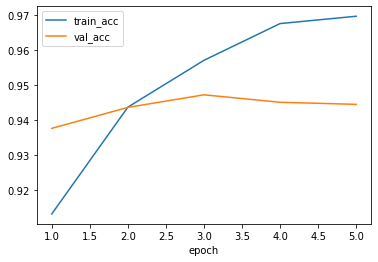

In [9]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['accuracy'],label='train_acc')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

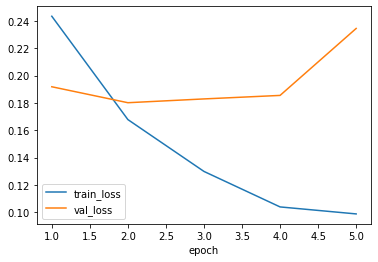

In [10]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['loss'],label='train_loss')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# # save the model weights
# classifier.save_weights('trained_classifier')

# 2. Predictions and Evaluations

In [11]:
bert=TFBertForSequenceClassification.from_pretrained(
            'bert-base-uncased')
bert.load_weights('model_param/Bert_pretrained_bert.h5')

optimizer=tf.keras.optimizers.Adam(learning_rate=2E-5)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

bert.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
bert.evaluate(test_ds)

3750/3750 [==============================] - 407s 107ms/step - loss: 0.1802 - accuracy: 0.9420 - l - ETA: 0s - loss: 0.1804 


[0.18016251921653748, 0.9419999718666077]

In [ ]:
# metrics.rand_score(test_sentence_label, label_pred)